# Swap Portfolio Backtest

## Imports

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
import numpy as np

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Tickers

In [2]:
# Define the symbols for ^GSPC, ^TNX, and ^VIX
symbols = ["^GSPC", "^TNX", "^VIX"]

## Collect Historical Data

In [3]:
# Calculate the start and end dates
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=5*365)).strftime("%Y-%m-%d")

# Retrieve historical data for the symbols
data = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]

# Calculate the daily returns for each symbol
returns = data.pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


## Fees

In [4]:
# Define the fee structure
fees = {
    "^GSPC": {"min_spread": 0.5, "margin_percentage": 5},
    "^TNX": {"min_spread": 3, "margin_percentage": 3},
    "^VIX": {"min_spread": 3, "margin_percentage": 3.5}
}

## Allocations

In [5]:
# Set the allocation percentages
allocations = {
    "^GSPC": 0.33,
    "^TNX": 0.33,
    "^VIX": 0.33
}

## Run Portfolio Simulation

In [6]:
# Calculate the portfolio returns based on the allocations and fees
portfolio_returns = returns[symbols[0]] * allocations[symbols[0]] * (1 - fees[symbols[0]]["min_spread"]/100) + \
                   returns[symbols[1]] * allocations[symbols[1]] * (1 - fees[symbols[1]]["min_spread"]/100) + \
                   returns[symbols[2]] * allocations[symbols[2]] * (1 - fees[symbols[2]]["min_spread"]/100)

# Calculate the cumulative returns of the portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()

# Calculate portfolio statistics
portfolio_value = 4_000 * cumulative_returns[-1]  # Final portfolio value
portfolio_gain = (portfolio_value - 4_000) / 4_000 * 100  # Portfolio gain (%)
annualized_return = (cumulative_returns[-1] ** (252 / len(cumulative_returns)) - 1) * 100  # Annualized return (%)
portfolio_std = portfolio_returns.std()  # Portfolio standard deviation

# Results

Final Portfolio Value: $18,680.24
Portfolio Gain: 367.01%
Annualized Return: 36.24%
Portfolio Standard Deviation: 0.02


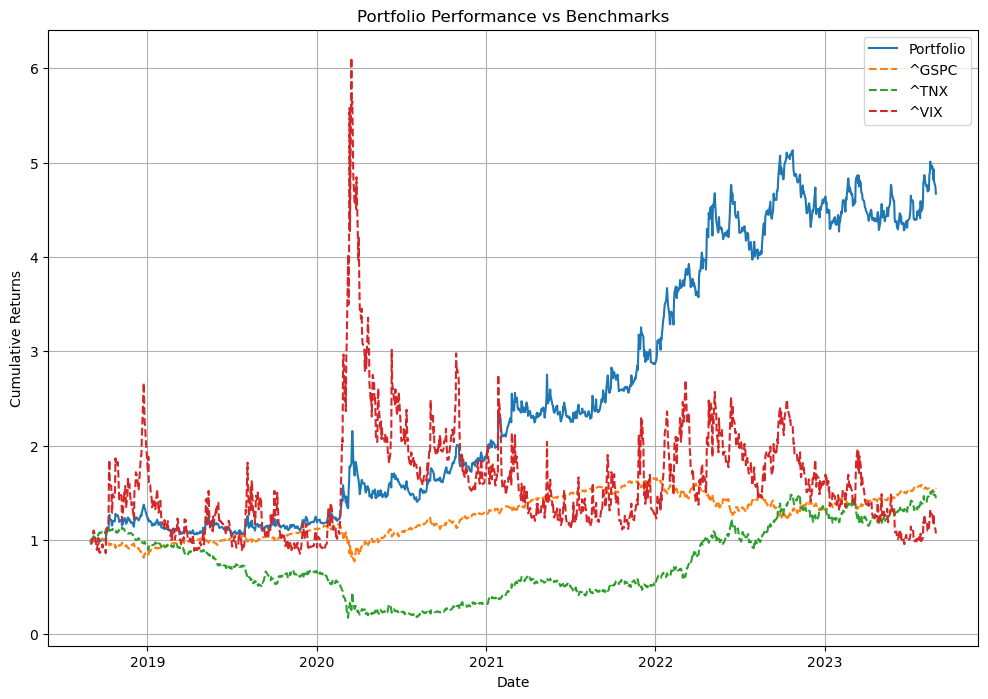

In [7]:
# Print portfolio statistics
print("Final Portfolio Value: ${:,.2f}".format(portfolio_value))
print("Portfolio Gain: {:.2f}%".format(portfolio_gain))
print("Annualized Return: {:.2f}%".format(annualized_return))
print("Portfolio Standard Deviation: {:.2f}".format(portfolio_std))

In [ ]:
# Save daily cumulative portfolio returns to CSV
cumulative_returns.to_csv("daily_cumulative_returns.csv")

# Plot the cumulative returns of the portfolio and its components
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns)
plt.plot((1 + returns[symbols[0]]).cumprod(), linestyle='--')
plt.plot((1 + returns[symbols[1]]).cumprod(), linestyle='--')
plt.plot((1 + returns[symbols[2]]).cumprod(), linestyle='--')
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Portfolio Performance vs Benchmarks")
plt.legend(["Portfolio", symbols[0], symbols[1], symbols[2]])
plt.grid(True)
plt.show()

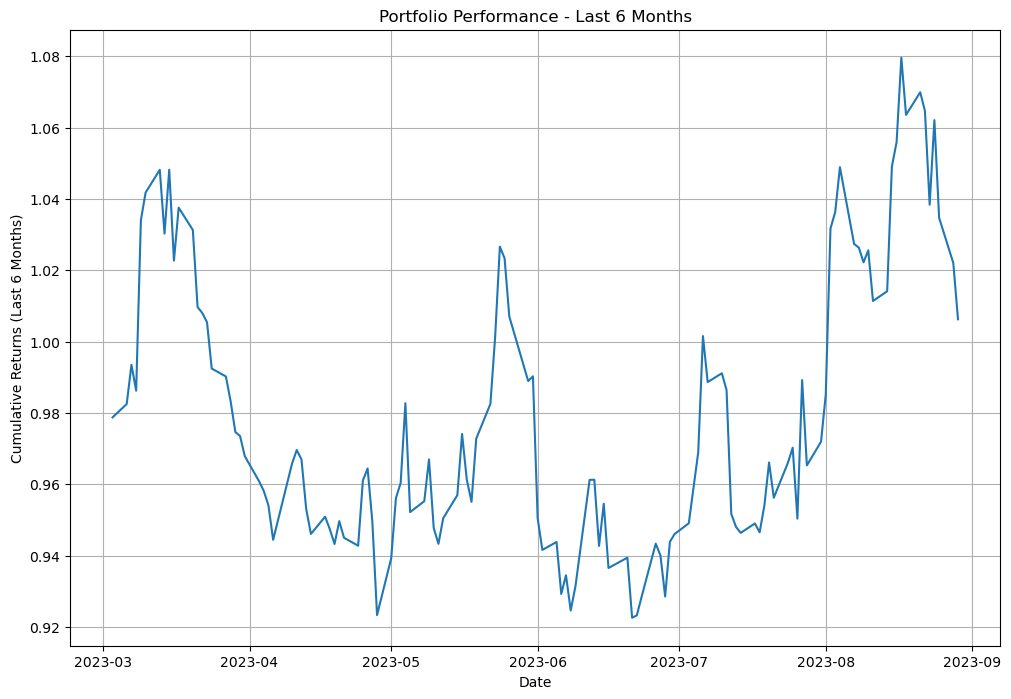

In [8]:

# Calculate the portfolio performance over the last 6 months
six_months_ago = (datetime.now() - timedelta(days=6*30)).strftime("%Y-%m-%d")
portfolio_returns_6m = portfolio_returns.loc[six_months_ago:end_date]
cumulative_returns_6m = (1 + portfolio_returns_6m).cumprod()

# Plot the cumulative returns of the portfolio over the last 6 months
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns_6m)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (Last 6 Months)")
plt.title("Portfolio Performance - Last 6 Months")
plt.grid(True)
plt.show()

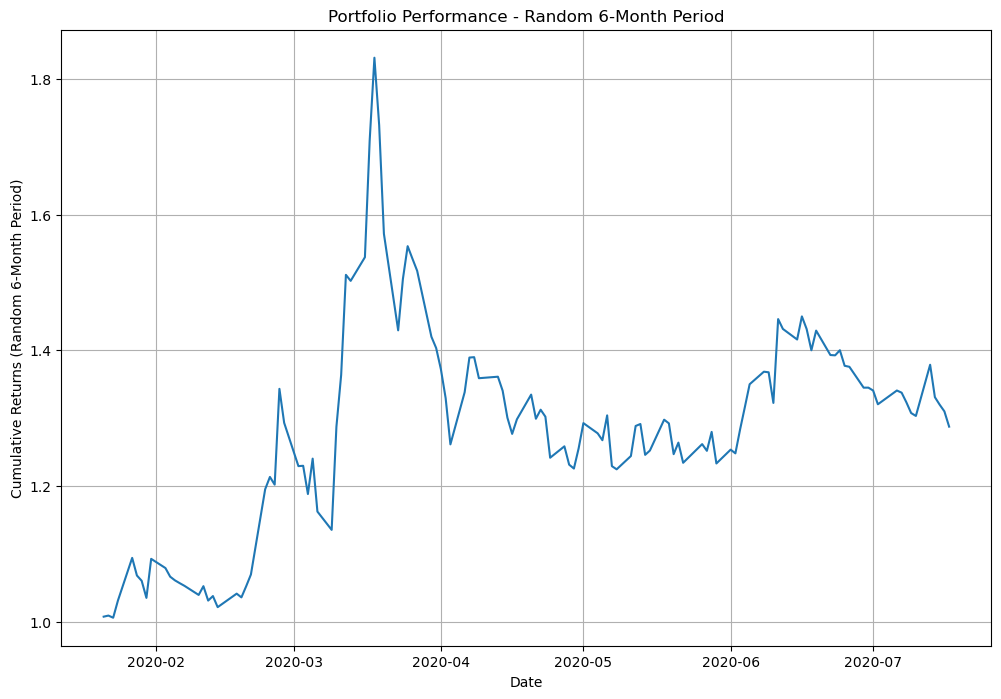

In [9]:
# Out of sample test: Calculate portfolio performance for a random 6-month period in the last 5 years
five_years_ago = (datetime.now() - timedelta(days=5*365)).strftime("%Y-%m-%d")
random_start = (datetime.strptime(five_years_ago, "%Y-%m-%d") + timedelta(days=random.randint(0, 5*365-180))).strftime("%Y-%m-%d")
random_end = (datetime.strptime(random_start, "%Y-%m-%d") + timedelta(days=6*30)).strftime("%Y-%m-%d")
random_returns = returns.loc[random_start:random_end]
random_portfolio_returns = (random_returns[symbols[0]] * allocations[symbols[0]] * (1 - fees[symbols[0]]["min_spread"]/100) +
                            random_returns[symbols[1]] * allocations[symbols[1]] * (1 - fees[symbols[1]]["min_spread"]/100) +
                            random_returns[symbols[2]] * allocations[symbols[2]] * (1 - fees[symbols[2]]["min_spread"]/100))
cumulative_random_returns = (1 + random_portfolio_returns).cumprod()

# Plot the cumulative returns of the portfolio for the random 6-month period
plt.figure(figsize=(12, 8))
plt.plot(cumulative_random_returns)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (Random 6-Month Period)")
plt.title("Portfolio Performance - Random 6-Month Period")
plt.grid(True)
plt.show()

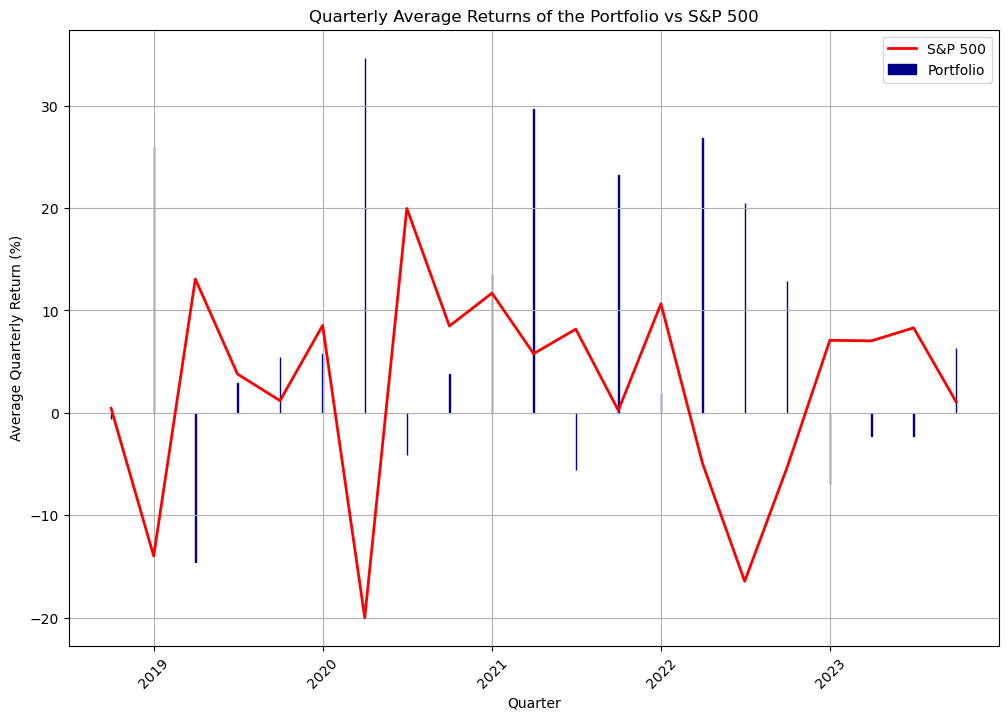

In [10]:
# Calculate quarterly average returns
quarterly_returns = portfolio_returns.resample('Q').apply(lambda x: (x + 1).prod() - 1)
sp500_quarterly_returns = returns[symbols[0]].resample('Q').apply(lambda x: (x + 1).prod() - 1)

# Plot the quarterly average returns with S&P 500 overlay
plt.figure(figsize=(12, 8))
bars = plt.bar(quarterly_returns.index, quarterly_returns * 100, color='steelblue')
plt.plot(sp500_quarterly_returns.index, sp500_quarterly_returns * 100, color='red', linewidth=2)
plt.xlabel("Quarter")
plt.ylabel("Average Quarterly Return (%)")
plt.title("Quarterly Average Returns of the Portfolio vs S&P 500")
plt.xticks(rotation=45)
plt.grid(True)

# Customize the color of the bars
for bar in bars:
    bar.set_color('darkblue')

plt.legend(["S&P 500","Portfolio"])
plt.show()

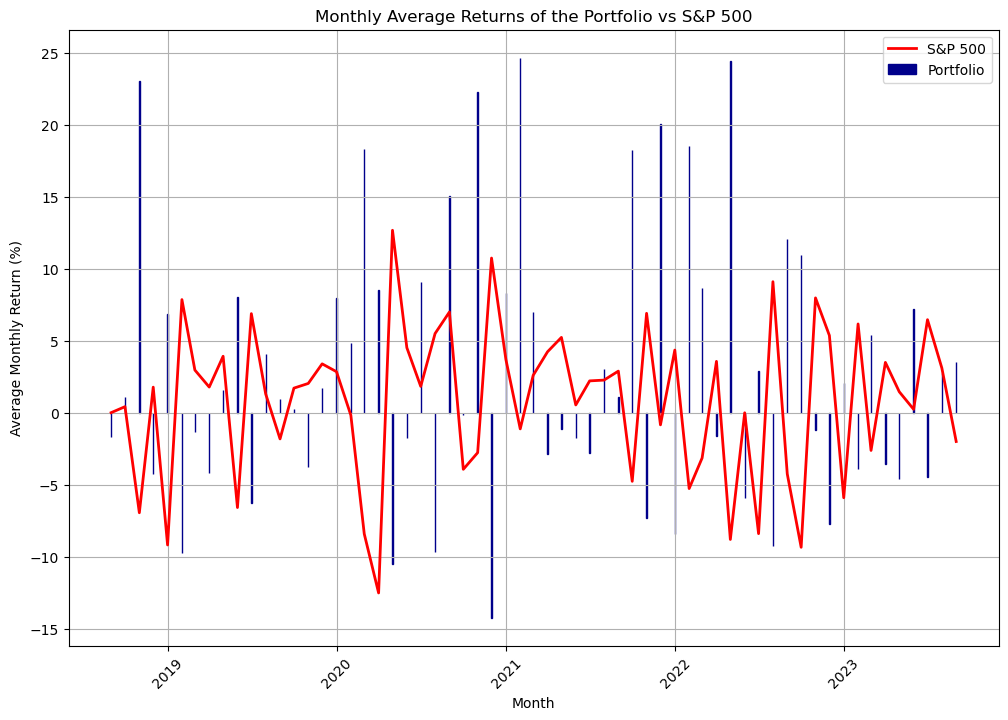

In [11]:
# Calculate monthly average returns
monthly_returns = portfolio_returns.resample('M').apply(lambda x: (x + 1).prod() - 1)
sp500_monthly_returns = returns[symbols[0]].resample('M').apply(lambda x: (x + 1).prod() - 1)

# Plot the monthly average returns with S&P 500 overlay
plt.figure(figsize=(12, 8))
bars = plt.bar(monthly_returns.index, monthly_returns * 100, color='steelblue')
plt.plot(sp500_monthly_returns.index, sp500_monthly_returns * 100, color='red', linewidth=2)
plt.xlabel("Month")
plt.ylabel("Average Monthly Return (%)")
plt.title("Monthly Average Returns of the Portfolio vs S&P 500")
plt.xticks(rotation=45)
plt.grid(True)

# Customize the color of the bars
for bar in bars:
    bar.set_color('darkblue')

plt.legend(["S&P 500","Portfolio"])
plt.show()